<span style="font-size:5em;">Neural network from scratch</span>

**Michał M.**

In this notebook I implement basic neural network using numpy and pandas. I do not use any well known frameworks as Tensorflow or Pytorch, it is just an exercise. I will publish it on Kaggle as a notebook for educational purposes.

The idea of this notebook is based on Jan Chorowski Neural Networks class conducted at Institute of Computer Science, University of Wrocław.

I will write the code first and then I would add some theory.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sopt

# Gradient descent and other optimization approaches

The Gradient Descent algorithm finds the minimum of a given function by taking small steps along the function's gradient. In pseudocode:

>$\Theta \leftarrow \Theta_0$
>
>**while** stop condition not met **do**
>
>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$
>
>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$ denotes $f$'s gradient at $\Theta$ and $\alpha$ is the step size, taking typically values from $10^{-4},\ldots,10^{-1}$.

In [259]:
# Rosenbrock functionm

def rosenbrock_v(x, a=1, b=100):
    """  
    Returns the value of Rosenbrock's function.
    
    Parameters
    ----------
    x : arguments as an array of length 2
    
    a, b : parameters of Rosenbrock's function
            
    Returns
    ----------
    foo : float, value of Rosenbrock's function at x
    """
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock(x):
    """
    Returns the value of Rosenbrock's function and its gradient.
    
    Parameters
    ----------
    x : arguments as an array of length 2
                
    Returns
    ----------
    foo : ndarray of shape (2,)
        - value : value of Rosenbrock's function
        - gradient : ndarray of shape (2,) containing gradient values 
    """
    a = 1
    b = 100
    value  = rosenbrock_v(x)
    dVdx0 = -2*(a - x[0]) - 2*b*(x[1]-x[0]**2) * 2*x[0]
    dVdx1 = 2*b * (x[1]-x[0]**2)
    gradient = np.array([dVdx0, dVdx1])    
    return np.array([value, gradient])

In [260]:
# gradient descent algorithm

def GD(f, x_zero, alpha=2e-3, stop_tolerance=1e-10, max_steps=1e6, verbose=False):
    """    
    Runs gradient descent algorithm on f.
    
    The basic iteration is:
    val, dVdX <- f(X)
    Theta <- -alpha * dVdX
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient]

        
    x_zero : starting point
        
    alpha : step length
    
    stop_tolerance : stop iterations when improvement is below this threhsold
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?
    
    Returns
    ----------
    Theta, history : tuple
        - X : argument for which f attain optimum
        - history : list of length num_steps containing tuples (Theta, (val, dValdX))
    """
    history = []
    
    x = x_zero
    value = np.inf
    
    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient = f(x)
        history.append([x, (value, gradient)])
        
        if np.abs(previous_value-value) < stop_tolerance:
            break
        
        x = x - alpha*gradient
        
        step += 1
    
    history.append([x, f(x)])
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x, len(history)))
    
    return x, history

In [261]:
initial_x = [-0.45, 2.25]
Xopt, Xhist = GD(rosenbrock, initial_x, alpha=2e-3, verbose=True)

values_hist = [t[1][0] for t in Xhist]


x = np.arange(-2.25,2.25,0.01)
y = np.arange(-1,2.5,0.01)
X,Y = np.meshgrid(x,y)
Z = rosenbrock_v([X, Y])

Found optimum at [0.99975021 0.99949949] in 9243 steps.


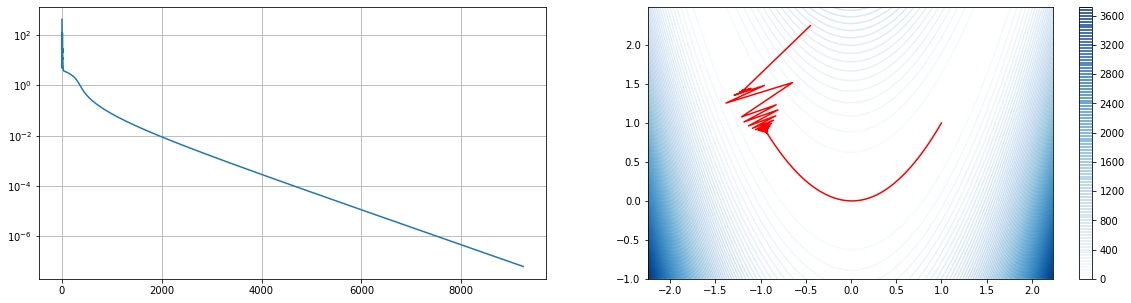

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].grid()
axes[0].set_yscale("log")
axes[0].plot(values_hist)

axes[1].plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red')
im = axes[1].contour(X, Y, Z, 100, cmap='Blues')
fig.colorbar(im, ax=axes[1])

plt.show()

In [263]:
# scipy BFGS algorithm
    
def fmin_l_bfgs_b_hist(f, x_zero, max_steps=15000, verbose=False):
    """
    Wrapper for fmin_l_bfgs_b function from scipy library. 
    Returns the optimal value of the underlying function and history of an optimization.
    
    Parameters
    ----------
    f : function to optimize
        
    x_zero : starting point
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?
    
    Returns
    ----------
    Theta, history : tuple
        - X : argument for which f attain optimum
        - history : list of length num_steps containing tuples (X, (val, dValdX))
    """
    history = []
    history.append([x_zero, tuple(f(x_zero))])

    x_optimal = sopt.fmin_l_bfgs_b(f, x_zero, maxiter=max_steps, callback=lambda x: history.append([x, tuple(f(x))]))[0]
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x_optimal, len(history)))
    
    return x_optimal, history

In [264]:
Xopt_bfgs, Xhist_bfgs = fmin_l_bfgs_b_hist(rosenbrock, initial_x, verbose=True)

values_hist_bfgs = [t[1][0] for t in Xhist_bfgs]

Found optimum at [0.99999992 0.99999983] in 38 steps.


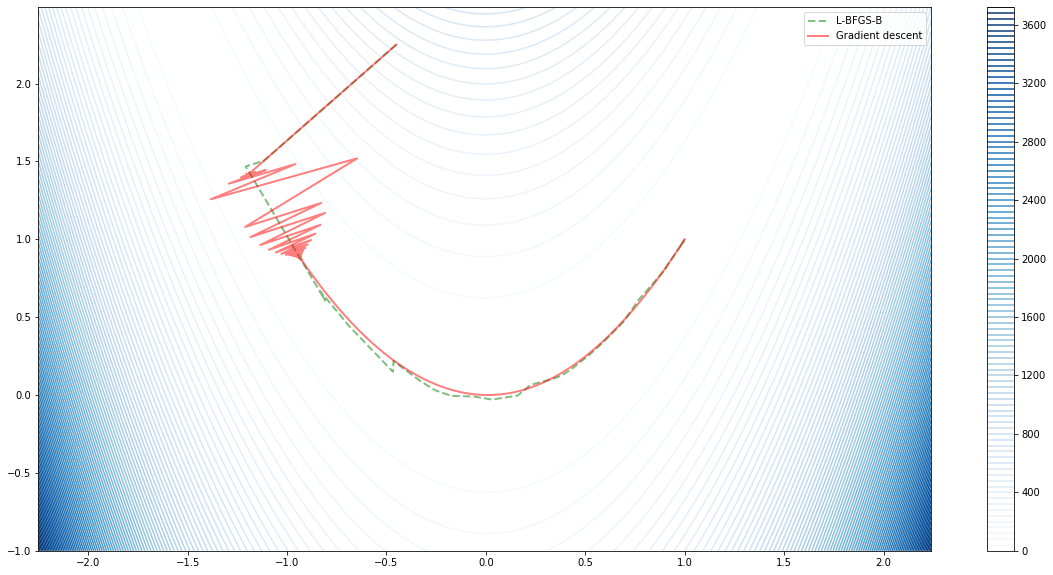

In [265]:
plt.subplots(figsize=(20, 10))

plt.plot([t[0][0] for t in Xhist_bfgs], [t[0][1] for t in Xhist_bfgs], '--', color='green', alpha=0.5, linewidth=2, label='L-BFGS-B')
plt.plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red', alpha=0.5, linewidth=2, label='Gradient descent')
plt.contour(X, Y, Z, 100, cmap='Blues')
plt.colorbar()
plt.legend()

plt.show()

In [266]:
# Newtod-Raphson method

def rosenbrock_hessian(x):
    """
    Returns the value of Rosenbrock's function, its gradient and Hessian.
    
    Parameters
    ----------
    x : arguments as an array of length 2
                
    Returns
    ----------
    foo : array of shape (3,)
        - value : value of Rosenbrock's function
        - gradient : ndarray of shape (2,)
        - hessian : ndarray of shape (2,2)
    """
    value, gradient = rosenbrock(x)
    hessian = np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]], 
                   [-400*x[0], 200]])
    
    return [value, gradient, hessian]

def backtracking_line_search(f, x, alpha=0.25, beta=0.5):
    """
    Backtracking line search needed for Newton-Rhapson method implementation.
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient, hessian]
        
    x_zero : starting point
    
    alpha, beta : parameters for algorithm
        
    Returns
    ----------
    t : float, parameter for optimal step
    """
    t = 1
    
    value, gradient, hessian = f(x)
    v = np.matmul(-np.linalg.inv(hessian), gradient)
    
    while f(x + t*v)[0] > f(x)[0] + alpha*t*gradient.dot(v):
        t *= beta
        
    return t


def Newton_Raphson(f, x_zero, alpha=0.25, beta=0.5, critical_step=1e4, gd_step=2e-3, stop_tolerance=1e-10, max_steps=1e6, verbose=False):
    """
    The Newton-Rhapson optimization method.
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient, hessian]
        
    x_zero : starting point
    
    alpha, beta : parameters for algorithm line search algorithm
        
    critical_step : after improvment below this value algorithm is switching to classic gradient descent
    
    gd_step : gradient descent step size
    
    stop_tolerance : stop iterations when improvement is below this threhsold
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?    
        
    Returns
    ----------
    t : float, parameter for optimal step
    """
    history = []
    
    x = x_zero
    value = np.inf
    
    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient, hessian = f(x)
        history.append([x, (value, gradient)])
        
        if np.abs(previous_value-value) < stop_tolerance:
            break
        
        if np.abs(previous_value-value) < critical_step:
            x = x - gd_step*gradient
        else:
            step = backtracking_line_search(f, x, alpha, beta)
            x = x - step*np.matmul(np.linalg.inv(hessian), gradient)
        
        step += 1
    
    history.append([x, f(x)])
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x, len(history)))
    
    return x, history

In [267]:
Xopt_newton, Xhist_newton = Newton(rosenbrock_hessian, initial_x, verbose=True)

values_hist_newton = [t[1][0] for t in Xhist_newton]

Found optimum at [1. 1.] in 20 steps.


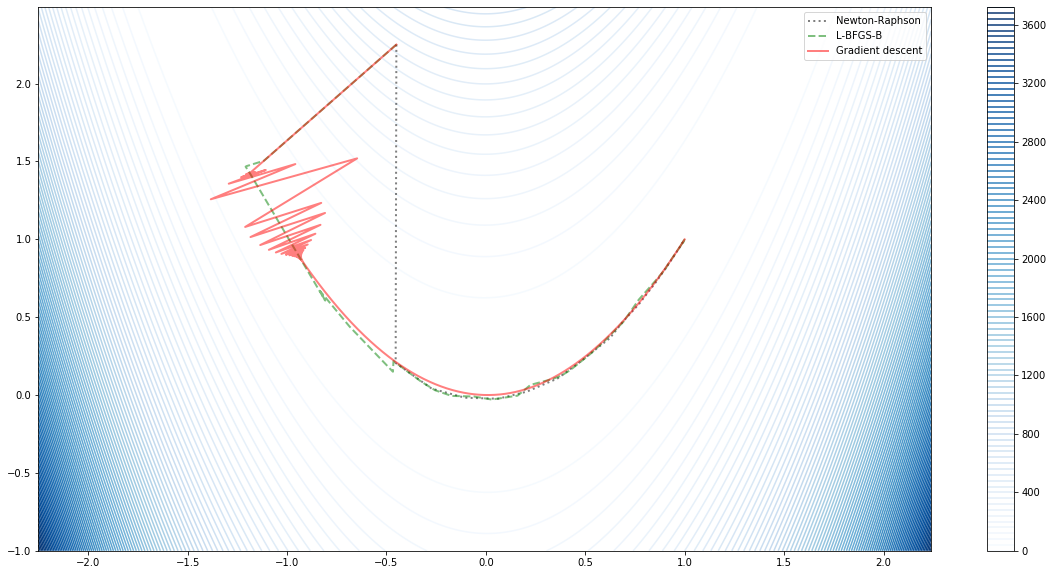

In [268]:
plt.subplots(figsize=(20, 10))

plt.plot([t[0][0] for t in Xhist_newton], [t[0][1] for t in Xhist_newton], ':', color='black', alpha=0.5, linewidth=2, label='Newton-Raphson')
plt.plot([t[0][0] for t in Xhist_bfgs], [t[0][1] for t in Xhist_bfgs], '--', color='green', alpha=0.5, linewidth=2, label='L-BFGS-B')
plt.plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red', alpha=0.5, linewidth=2, label='Gradient descent')
plt.contour(X, Y, Z, 100, cmap='Blues')
plt.colorbar()
plt.legend()

plt.show()